In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 15-22-31.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 15-22-31_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_11-2.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary_11-2.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752258036.971519 23645159 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752258036.991203 23645849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752258037.001733 23645851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752258038.647013 23645849 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 4731
Frames with at least 1 hand detected: 1881
Detection rate: 39.76%


In [11]:
df = pd.read_csv("hand_landmarks_11-2.csv")

print("Shape:", df.shape)
df

Shape: (161490, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.00,Left,0,NaN,NaN,NaN,0
1,0,0.00,Left,1,NaN,NaN,NaN,0
2,0,0.00,Left,2,NaN,NaN,NaN,0
3,0,0.00,Left,3,NaN,NaN,NaN,0
4,0,0.00,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
161485,4730,78.85,Right,16,NaN,NaN,NaN,0
161486,4730,78.85,Right,17,NaN,NaN,NaN,0
161487,4730,78.85,Right,18,NaN,NaN,NaN,0
161488,4730,78.85,Right,19,NaN,NaN,NaN,0


In [14]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [17]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,35,0.583,Left,1,0.603289,0.576888,0.565278,0.550103,0.536404,0.615150,...,0.001026,-0.001852,0.012955,0.018581,0.017443,0.015544,0.023473,0.029268,0.031328,0.032020
1,36,0.600,Left,1,0.605004,0.577060,0.565774,0.550082,0.534938,0.616473,...,0.007466,0.006777,0.017492,0.025599,0.026270,0.025689,0.031401,0.040001,0.043494,0.045221
2,37,0.617,Left,1,0.603921,0.576834,0.565862,0.550684,0.537177,0.616936,...,0.010472,0.008961,0.019760,0.028831,0.029457,0.028559,0.032988,0.042348,0.046097,0.047900
3,38,0.633,Left,1,0.609694,0.581504,0.575325,0.566920,0.555802,0.625879,...,0.013029,0.012912,0.022296,0.031859,0.033564,0.033618,0.037791,0.048592,0.053737,0.056521
4,39,0.650,Left,1,0.608751,0.580393,0.574561,0.566487,0.557189,0.624462,...,0.012935,0.013302,0.023492,0.032130,0.033196,0.033322,0.040353,0.050330,0.054457,0.056834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,4433,73.883,Left,1,0.584459,0.565188,0.555793,0.546612,0.543352,0.610389,...,-0.026370,-0.027423,-0.013578,-0.014836,-0.014784,-0.014948,-0.010462,-0.010261,-0.007948,-0.005582
1933,4434,73.900,Left,1,0.584322,0.563773,0.553922,0.545753,0.542905,0.611025,...,-0.021088,-0.022559,-0.006902,-0.008140,-0.008799,-0.009173,-0.001535,-0.002067,-0.000871,0.000981
1934,4435,73.917,Left,1,0.600330,0.576930,0.563870,0.550206,0.538670,0.612455,...,-0.026301,-0.029266,-0.017428,-0.021217,-0.023982,-0.026240,-0.019114,-0.021580,-0.021430,-0.021016
1935,4436,73.933,Left,1,0.603184,0.578178,0.564623,0.554301,0.544855,0.610119,...,-0.039931,-0.043380,-0.024828,-0.032654,-0.036099,-0.038577,-0.025562,-0.032492,-0.034545,-0.035362


In [20]:
df2 = pd.read_csv("hand_lable_11-2.csv")

print("Shape:", df.shape)
df2

Shape: (161490, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,other,NaN,START,5.817,D:/Data Science/UOB/DS_project/Full Study/11-2...,349,NaN,NaN
1,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,other,NaN,STOP,6.333,D:/Data Science/UOB/DS_project/Full Study/11-2...,380,NaN,NaN
2,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,lift,NaN,START,6.350,D:/Data Science/UOB/DS_project/Full Study/11-2...,381,NaN,NaN
3,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,lift,NaN,STOP,6.783,D:/Data Science/UOB/DS_project/Full Study/11-2...,407,NaN,NaN
4,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,hold,NaN,START,8.417,D:/Data Science/UOB/DS_project/Full Study/11-2...,505,NaN,NaN
5,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,hold,NaN,STOP,9.450,D:/Data Science/UOB/DS_project/Full Study/11-2...,567,NaN,NaN
6,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,hold,NaN,START,11.467,D:/Data Science/UOB/DS_project/Full Study/11-2...,688,NaN,NaN
7,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,hold,NaN,STOP,11.783,D:/Data Science/UOB/DS_project/Full Study/11-2...,707,NaN,NaN
8,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,press,NaN,START,11.800,D:/Data Science/UOB/DS_project/Full Study/11-2...,708,NaN,NaN
9,11-2,2025-07-12 19:18:56.294,NaN,57.05,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,78.85,60.0,NaN,press,NaN,STOP,12.117,D:/Data Science/UOB/DS_project/Full Study/11-2...,727,NaN,NaN


In [23]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,5.817,6.333,349,380
1,lift,6.350,6.783,381,407
2,hold,8.417,9.450,505,567
3,hold,11.467,11.783,688,707
4,press,11.800,12.117,708,727
5,hold,12.133,12.400,728,744
6,adjust,13.633,19.650,818,1179
7,rotate,19.667,29.717,1180,1783
8,hold,38.067,38.567,2284,2314
9,press,38.583,38.900,2315,2334


In [26]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_19312/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,35,0.583,Left,1,0.603289,0.576888,0.565278,0.550103,0.536404,0.615150,...,-0.001852,0.012955,0.018581,0.017443,0.015544,0.023473,0.029268,0.031328,0.032020,NaN
1,36,0.600,Left,1,0.605004,0.577060,0.565774,0.550082,0.534938,0.616473,...,0.006777,0.017492,0.025599,0.026270,0.025689,0.031401,0.040001,0.043494,0.045221,NaN
2,37,0.617,Left,1,0.603921,0.576834,0.565862,0.550684,0.537177,0.616936,...,0.008961,0.019760,0.028831,0.029457,0.028559,0.032988,0.042348,0.046097,0.047900,NaN
3,38,0.633,Left,1,0.609694,0.581504,0.575325,0.566920,0.555802,0.625879,...,0.012912,0.022296,0.031859,0.033564,0.033618,0.037791,0.048592,0.053737,0.056521,NaN
4,39,0.650,Left,1,0.608751,0.580393,0.574561,0.566487,0.557189,0.624462,...,0.013302,0.023492,0.032130,0.033196,0.033322,0.040353,0.050330,0.054457,0.056834,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,4433,73.883,Left,1,0.584459,0.565188,0.555793,0.546612,0.543352,0.610389,...,-0.027423,-0.013578,-0.014836,-0.014784,-0.014948,-0.010462,-0.010261,-0.007948,-0.005582,NaN
1933,4434,73.900,Left,1,0.584322,0.563773,0.553922,0.545753,0.542905,0.611025,...,-0.022559,-0.006902,-0.008140,-0.008799,-0.009173,-0.001535,-0.002067,-0.000871,0.000981,NaN
1934,4435,73.917,Left,1,0.600330,0.576930,0.563870,0.550206,0.538670,0.612455,...,-0.029266,-0.017428,-0.021217,-0.023982,-0.026240,-0.019114,-0.021580,-0.021430,-0.021016,NaN
1935,4436,73.933,Left,1,0.603184,0.578178,0.564623,0.554301,0.544855,0.610119,...,-0.043380,-0.024828,-0.032654,-0.036099,-0.038577,-0.025562,-0.032492,-0.034545,-0.035362,NaN


In [29]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    831
NaN       475
adjust    333
hold      171
press      89
other      32
lift        6
Name: count, dtype: int64


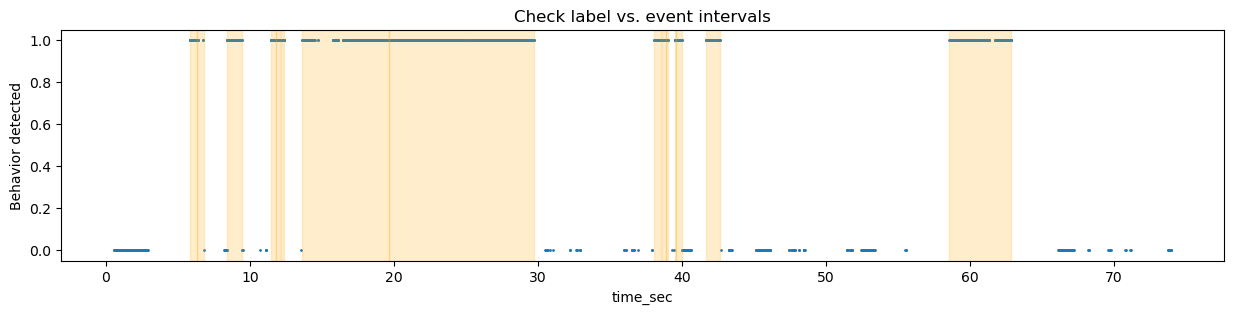

In [32]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [35]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
140,349,5.817,Left,1,0.687275,0.681500,0.662519,0.638122,0.618009,0.683832,...,-0.023685,0.014493,0.000527,-0.010436,-0.013339,0.018753,0.005414,-0.001613,-0.002631,other
141,350,5.833,Left,1,0.691391,0.678628,0.658109,0.634508,0.616302,0.698049,...,-0.030338,0.010656,-0.001448,-0.011472,-0.014763,0.018348,0.006599,-0.000235,-0.001810,other
142,351,5.850,Left,1,0.693133,0.673167,0.651898,0.627178,0.606952,0.703278,...,-0.002369,0.030552,0.030348,0.020111,0.013545,0.049571,0.046983,0.039841,0.035669,other
143,352,5.867,Left,1,0.694703,0.672380,0.652285,0.628813,0.608335,0.704849,...,-0.010679,0.025011,0.023726,0.013401,0.006925,0.043931,0.040775,0.033460,0.029308,other
144,353,5.883,Left,1,0.681344,0.658256,0.637905,0.614323,0.592739,0.685346,...,0.009095,0.030360,0.033454,0.026184,0.021397,0.048561,0.049333,0.044744,0.042223,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,3768,62.800,Right,1,0.423783,0.495266,0.545116,0.584527,0.624855,0.506209,...,0.114081,0.090097,0.123811,0.136128,0.142488,0.119941,0.148749,0.159683,0.167410,rotate
1848,3769,62.817,Right,1,0.422895,0.495833,0.545690,0.584709,0.624128,0.506906,...,0.120276,0.093386,0.128629,0.141785,0.148642,0.122860,0.152985,0.164587,0.172758,rotate
1849,3770,62.833,Right,1,0.409177,0.459361,0.495524,0.524950,0.558012,0.460802,...,0.053795,0.062530,0.084549,0.088322,0.088374,0.096050,0.115031,0.119618,0.121905,rotate
1850,3771,62.850,Right,1,0.380268,0.425112,0.457356,0.481148,0.495989,0.420896,...,-0.026167,0.001359,-0.002306,-0.008033,-0.010729,0.006745,0.007953,0.007000,0.007476,rotate


In [59]:
df_wide['dataset_id'] = '1102'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
140,1102,349,5.817,Left,1,0.687275,0.681500,0.662519,0.638122,0.618009,...,-0.023685,0.014493,0.000527,-0.010436,-0.013339,0.018753,0.005414,-0.001613,-0.002631,other
141,1102,350,5.833,Left,1,0.691391,0.678628,0.658109,0.634508,0.616302,...,-0.030338,0.010656,-0.001448,-0.011472,-0.014763,0.018348,0.006599,-0.000235,-0.001810,other
142,1102,351,5.850,Left,1,0.693133,0.673167,0.651898,0.627178,0.606952,...,-0.002369,0.030552,0.030348,0.020111,0.013545,0.049571,0.046983,0.039841,0.035669,other
143,1102,352,5.867,Left,1,0.694703,0.672380,0.652285,0.628813,0.608335,...,-0.010679,0.025011,0.023726,0.013401,0.006925,0.043931,0.040775,0.033460,0.029308,other
144,1102,353,5.883,Left,1,0.681344,0.658256,0.637905,0.614323,0.592739,...,0.009095,0.030360,0.033454,0.026184,0.021397,0.048561,0.049333,0.044744,0.042223,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,1102,3768,62.800,Right,1,0.423783,0.495266,0.545116,0.584527,0.624855,...,0.114081,0.090097,0.123811,0.136128,0.142488,0.119941,0.148749,0.159683,0.167410,rotate
1848,1102,3769,62.817,Right,1,0.422895,0.495833,0.545690,0.584709,0.624128,...,0.120276,0.093386,0.128629,0.141785,0.148642,0.122860,0.152985,0.164587,0.172758,rotate
1849,1102,3770,62.833,Right,1,0.409177,0.459361,0.495524,0.524950,0.558012,...,0.053795,0.062530,0.084549,0.088322,0.088374,0.096050,0.115031,0.119618,0.121905,rotate
1850,1102,3771,62.850,Right,1,0.380268,0.425112,0.457356,0.481148,0.495989,...,-0.026167,0.001359,-0.002306,-0.008033,-0.010729,0.006745,0.007953,0.007000,0.007476,rotate


In [61]:
behavior_counts = df_wide['behavior'].value_counts()

print(behavior_counts)


behavior
rotate    831
adjust    333
hold      171
press      89
other      32
lift        6
Name: count, dtype: int64


In [63]:
df_wide.to_csv("handlandmark_wide_11-2.csv", index=False)